In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier

In [2]:
# Setting random seed
np.random.seed(1234)

In [3]:
# Load the data
data = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data Cleaning

In [4]:
to_drop = ['customerID']
data = data.drop(to_drop, axis=1)

In [5]:
data['TotalCharges'] = data['TotalCharges'].replace('', None)
data['TotalCharges'] = data['TotalCharges'].replace(' ', None)

In [6]:
data['TotalCharges'] = data['TotalCharges'].astype(float)
data = data.dropna()
data = data.reset_index().drop('index', axis=1)

# Preprocessing

In [7]:
for column in data.columns:
    if len(np.unique(data[column])) == 2:
        data[column] = pd.factorize(data[column])[0]

In [8]:
to_be_onehot = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
          'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
          'Contract', 'PaymentMethod']

for column in to_be_onehot:
    # create an instance of OneHotEncoder
    ohe = OneHotEncoder()

    # use fit_transform() to convert the string variable to one-hot-encoded data
    data_encoded = ohe.fit_transform(data[[column]]).toarray()

    # create a new DataFrame with the one-hot-encoded data
    data_onehot = pd.DataFrame(data_encoded, columns=ohe.get_feature_names_out([column]))
    
    data = pd.concat([data, data_onehot], axis=1)
    data = data.drop(column, axis=1)

In [9]:
X = data.drop('Churn', axis=1).values.astype(float)
y = data['Churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Random Forest
Random Forest is a supervised machine learning algorithm used for classification, regression, and other tasks using decision trees. It is an ensemble learning method that creates a set of decision trees from a randomly selected subset of the training set. The algorithm then collects the votes from different decision trees to decide the final prediction. Random Forest is a powerful algorithm that can handle high-dimensional datasets with many features and can also handle missing data.

# Random Forest in Scikit-Learn
Scikit-Learn is a popular Python library for machine learning. It provides an implementation of the Random Forest algorithm through the RandomForestClassifier and RandomForestRegressor classes. These classes are built on top of Scikit-Learn's decision tree implementation and provide additional functionality for building and tuning random forest models.

To use Random Forest in Scikit-Learn, you can follow these steps:
1. Import the necessary modules: "RandomForestClassifier" or "RandomForestRegressor" from "sklearn.ensemble", "GridSearchCV" from "sklearn.model_selection", and any other necessary modules.

2. Define the parameter grid for the hyperparameters you want to tune. For example, you might want to tune the number of trees "n_estimators", the maximum depth of each tree "max_depth", and the minimum number of samples required to split an internal node "min_samples_split".

3. Create an instance of the "RandomForestClassifier" or "RandomForestRegressor" with default hyperparameters.

4. Create an instance of "GridSearchCV" with the random forest instance, the parameter grid, and any other necessary arguments such as cross-validation folds.

5. Fit the "GridSearchCV" instance to your training data.

6. Access the best estimator using the "best_estimator_" attribute of the "GridSearchCV" instance.

7. Use the best estimator to make predictions on new data.

In [10]:
# Define hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [11]:
# Create a random forest classifier
rf = RandomForestClassifier()

In [12]:
# Create grid search object
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)

In [13]:
# Fit grid search object to data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [14]:
# Print best hyperparameters
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [15]:
rf_best = grid_search.best_estimator_

pred = rf_best.predict(X_test)

In [16]:
accuracy_score(y_test, pred)

0.7884524372929484

In [17]:
confusion_matrix(y_test, pred)

array([[1387,  165],
       [ 282,  279]])

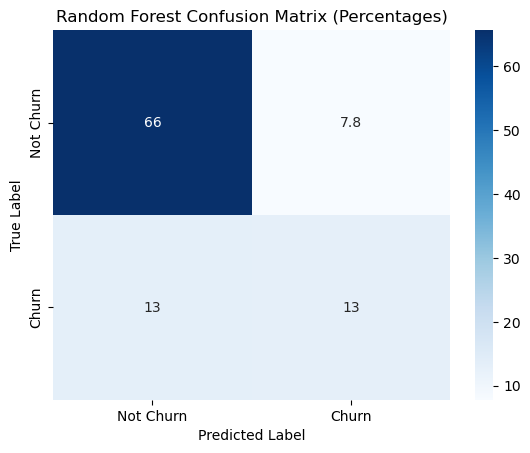

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Calculate the total number of samples
total_samples = np.sum(cm)

# Calculate the percentage of each cell in the confusion matrix
cm_percent = cm / total_samples * 100

class_labels = ['Not Churn', 'Churn']

# Create a pandas DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm_percent, index=class_labels, columns=class_labels)

# Plot the confusion matrix with annotations using seaborn's heatmap function
sns.heatmap(cm_df, annot=True, cmap='Blues')

# Customize the plot by adding a title and axis labels
plt.title('Random Forest Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

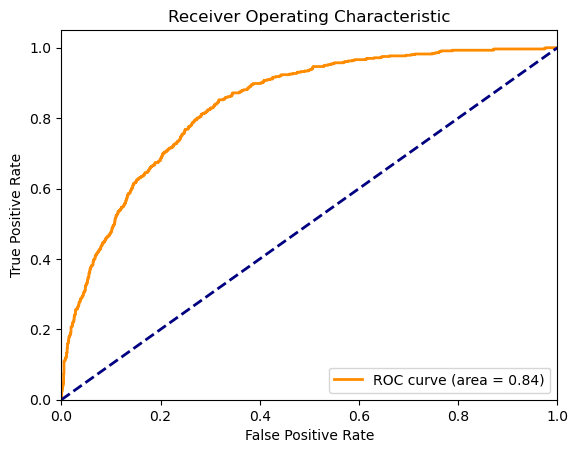

In [19]:
# Calculate the predicted probabilities for each class using current model
y_score = rf_best.predict_proba(X_test)

# Calculate the FPR, TPR, and classification thresholds using the roc_curve() function
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using matplotlib
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plot
plt.show()

# Gradient Boosting
Gradient Boosting is a machine learning technique used for both regression and classification problems. It is an ensemble method that combines several weak learners into a single strong learner in an iterative fashion. The weak learners are typically decision trees. Gradient Boosting works by iteratively adding decision trees to the model, with each tree correcting the errors of the previous one. The final prediction is the weighted sum of the predictions of all the trees.
# Gradient Boosting in Scikit-Learn
Scikit-Learn provides an implementation of Gradient Boosting for both regression and classification problems through the "GradientBoostingRegressor" and "GradientBoostingClassifier" classes, respectively. These classes are built on top of Scikit-Learn's decision tree implementation and provide additional functionality for building and tuning Gradient Boosting models.

To use Gradient Boosting in Scikit-Learn, you can follow these steps:
1. Import the necessary modules: "GradientBoostingRegressor" or "GradientBoostingClassifier" from "sklearn.ensemble", "GridSearchCV" from "sklearn.model_selection", and any other necessary modules.

2. Define the parameter grid for the hyperparameters you want to tune. For example, you might want to tune the number of trees "n_estimators", the maximum depth of each tree "max_depth", and the learning rate "learning_rate".

3. Create an instance of the "GradientBoostingRegressor" or "GradientBoostingClassifier" with default hyperparameters.

4. Create an instance of "GridSearchCV" with the Gradient Boosting instance, the parameter grid, and any other necessary arguments such as cross-validation folds.

5. Fit the "GridSearchCV" instance to your training data.

6. Access the best estimator using the "best_estimator_" attribute of the "GridSearchCV" instance.

7. Use the best estimator to make predictions on new data.

In [20]:
# Define parameter grid
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
}

In [21]:
# Create GradientBoostingClassifier instance
gb = GradientBoostingClassifier()

In [22]:
# Create GridSearchCV instance
grid_search = GridSearchCV(gb, param_grid=param_grid, cv=3)

In [23]:
# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000]})

In [24]:
# Print best hyperparameters
print(grid_search.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


In [25]:
gb_best =  grid_search.best_estimator_

pred = gb_best.predict(X_test)

In [26]:
accuracy_score(y_test, pred)

0.79649787032655

In [27]:
confusion_matrix(y_test, pred)

array([[1398,  154],
       [ 276,  285]])

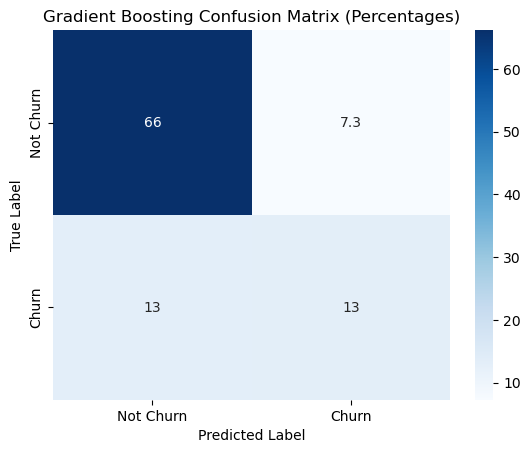

In [28]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Calculate the total number of samples
total_samples = np.sum(cm)

# Calculate the percentage of each cell in the confusion matrix
cm_percent = cm / total_samples * 100

class_labels = ['Not Churn', 'Churn']

# Create a pandas DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm_percent, index=class_labels, columns=class_labels)

# Plot the confusion matrix with annotations using seaborn's heatmap function
sns.heatmap(cm_df, annot=True, cmap='Blues')

# Customize the plot by adding a title and axis labels
plt.title('Gradient Boosting Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

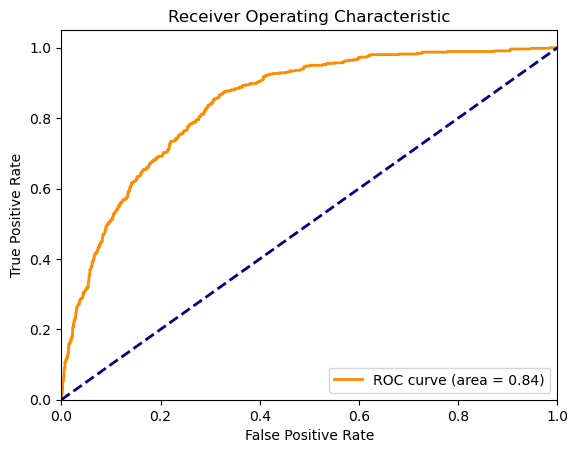

In [29]:
# Calculate the predicted probabilities for each class using current model
y_score = gb_best.predict_proba(X_test)

# Calculate the FPR, TPR, and classification thresholds using the roc_curve() function
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using matplotlib
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plot
plt.show()

# ExtraTrees Classifier
ExtraTrees Classifier is an ensemble tree-based machine learning approach that uses randomization to reduce variance and computational cost compared to Random Forest. It can be used for classification or regression, in scenarios where computational cost is a concern and where the data is not normally distributed. ExtraTrees Classifier creates a group of unpruned decision trees using the traditional top-down method and aggregates the results from the group of decision trees to output a prediction.

## Differences between Extra Trees and Random Forest
Extra Trees and Random Forest are two similar ensemble methods that construct multiple trees during training time over the entire dataset. However, there are some differences between them. In Extra Trees, it selects a random split to divide the parent node into two random child nodes, while in Random Forest, it selects the best split among a random subset of features. Additionally, Extra Trees constructs trees over every observation in the dataset but with different subsets of features.

## Implementing ExtraTrees Classifier in Scikit-Learn
Scikit-Learn provides an implementation of ExtraTrees Classifier through the "ExtraTreesClassifier" class. To use it, you can follow these steps:

1. Import the necessary modules: "ExtraTreesClassifier" from "sklearn.ensemble", "GridSearchCV" from "sklearn.model_selection", and any other necessary modules.

2. Define the parameter grid for the hyperparameters you want to tune. For example, you might want to tune the number of trees "n_estimators", the maximum depth of each tree "max_depth", and the minimum number of samples required to split an internal node "min_samples_split".

3. Create an instance of the "ExtraTreesClassifier" with default hyperparameters.

4. Create an instance of "GridSearchCV" with the "ExtraTreesClassifier" instance, the parameter grid, and any other necessary arguments such as cross-validation folds.

5. Fit the "GridSearchCV" instance to your training data.

6. Access the best estimator using the "best_estimator_" attribute of the "GridSearchCV" instance.

7. Use the best estimator to make predictions on new data.

In [30]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

In [31]:
# Create ExtraTreesClassifier instance
et = ExtraTreesClassifier()

In [32]:
# Create GridSearchCV instance
grid_search = GridSearchCV(et, param_grid=param_grid, cv=5)

In [33]:
# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500, 1000]})

In [34]:
et_best = grid_search.best_estimator_

pred = et_best.predict(X_test)

In [35]:
accuracy_score(y_test, pred)

0.7785139611926172

In [36]:
confusion_matrix(y_test, pred)

array([[1416,  136],
       [ 332,  229]])

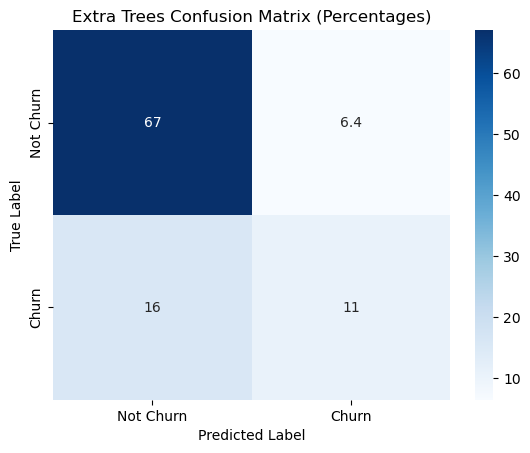

In [37]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Calculate the total number of samples
total_samples = np.sum(cm)

# Calculate the percentage of each cell in the confusion matrix
cm_percent = cm / total_samples * 100

class_labels = ['Not Churn', 'Churn']

# Create a pandas DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm_percent, index=class_labels, columns=class_labels)

# Plot the confusion matrix with annotations using seaborn's heatmap function
sns.heatmap(cm_df, annot=True, cmap='Blues')

# Customize the plot by adding a title and axis labels
plt.title('Extra Trees Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

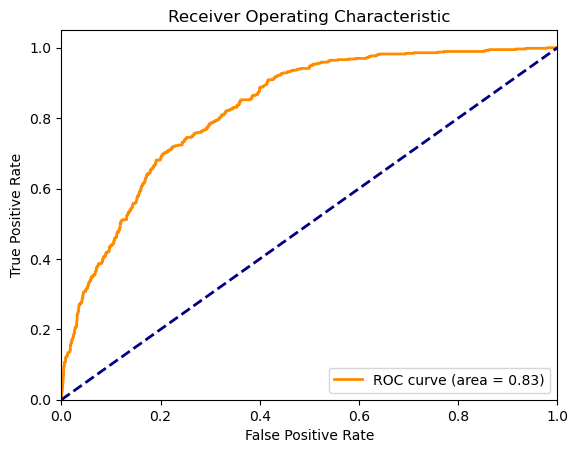

In [38]:
# Calculate the predicted probabilities for each class using current model
y_score = et_best.predict_proba(X_test)

# Calculate the FPR, TPR, and classification thresholds using the roc_curve() function
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using matplotlib
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plot
plt.show()

# Bagging Classifier
Bagging Classifier is an ensemble meta-estimator that fits base classifiers on random subsets of the original dataset and then aggregates their individual predictions to form a final prediction. It is an easy-to-use and effective method for improving the performance of a single model. Bagging stands for Bootstrap Aggregating, which is an ensemble machine learning technique that combines the predictions of multiple models to improve the overall performance of the system. The Bagging Classifier uses bootstrap resampling to generate multiple different subsets of the training data
## Implementing Bagging Classifier in Scikit-Learn
Scikit-Learn provides an implementation of Bagging Classifier through the "BaggingClassifier" class. To use it, you can follow these steps:

1. Import the necessary modules: "BaggingClassifier" from "sklearn.ensemble", "GridSearchCV" from "sklearn.model_selection", and any other necessary modules.

2. Define the parameter grid for the hyperparameters you want to tune. For example, you might want to tune the number of trees "n_estimators", the maximum depth of each tree "max_depth", and the minimum number of samples required to split an internal node "min_samples_split".

3. Create an instance of the "BaggingClassifier" with default hyperparameters.

4. Create an instance of "GridSearchCV" with the Bagging Classifier instance, the parameter grid, and any other necessary arguments such as cross-validation folds.

5. Fit the GridSearchCV instance to your training data.

6. Access the best estimator using the "best_estimator_" attribute of the "GridSearchCV" instance.

7. Use the best estimator to make predictions on new data.

In [39]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

In [40]:
# Create BaggingClassifier instance
bc = BaggingClassifier()

In [41]:
# Create GridSearchCV instance
grid_search = GridSearchCV(bc, param_grid=param_grid, cv=3)

In [42]:
# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=BaggingClassifier(),
             param_grid={'max_features': [0.5, 1.0], 'max_samples': [0.5, 1.0],
                         'n_estimators': [100, 500, 1000]})

In [43]:
bc_best = grid_search.best_estimator_

pred = bc_best.predict(X_test)

In [44]:
accuracy_score(y_test, pred)

0.7884524372929484

In [45]:
confusion_matrix(y_test, pred)

array([[1397,  155],
       [ 292,  269]])

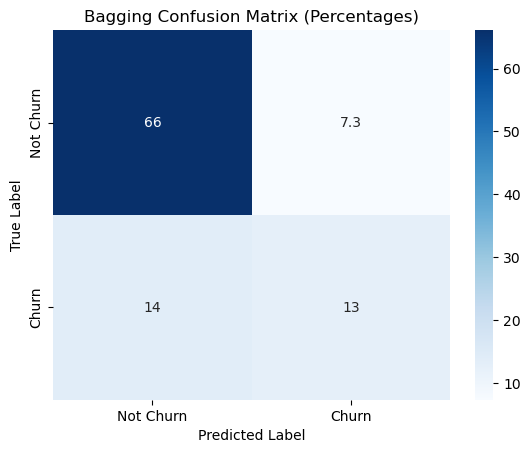

In [46]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Calculate the total number of samples
total_samples = np.sum(cm)

# Calculate the percentage of each cell in the confusion matrix
cm_percent = cm / total_samples * 100

class_labels = ['Not Churn', 'Churn']

# Create a pandas DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm_percent, index=class_labels, columns=class_labels)

# Plot the confusion matrix with annotations using seaborn's heatmap function
sns.heatmap(cm_df, annot=True, cmap='Blues')

# Customize the plot by adding a title and axis labels
plt.title('Bagging Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

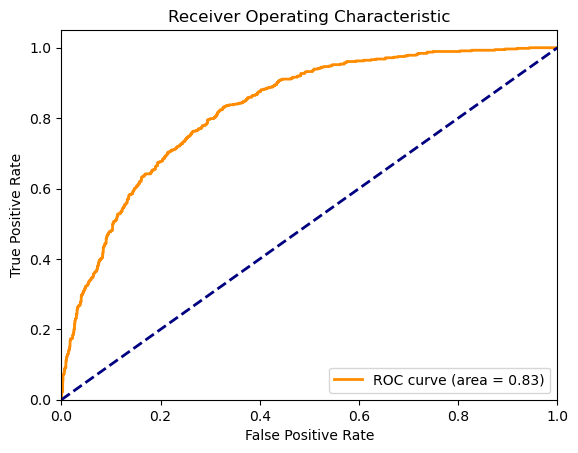

In [47]:
# Calculate the predicted probabilities for each class using current model
y_score = bc_best.predict_proba(X_test)

# Calculate the FPR, TPR, and classification thresholds using the roc_curve() function
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using matplotlib
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plot
plt.show()

# Logistic Regression
Logistic regression is a type of supervised learning algorithm used for classification tasks. It estimates the probability of an event occurring based on one or more independent variables.The output of logistic regression is a binary value (0 or 1, yes/no, true/false).

Here are the general steps to perform logistic regression using scikit-learn:

1. Import the necessary packages, classes, and functions.
2. Load the data.
3. Transform the data if necessary.
4. Fit the logistic regression model to the data.
5. Evaluate the performance of the model.

In [48]:
# Define parameter grid
param_grid = {
    'Cs': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

In [49]:
# Create LogisticRegressionCV instance
lr = LogisticRegressionCV()

In [50]:
# Create GridSearchCV instance
grid_search = GridSearchCV(lr, param_grid=param_grid, cv=3)

In [51]:
# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

/home/gholizadeh/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gholizadeh/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/home/gholizadeh/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gholizadeh/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

GridSearchCV(cv=3, estimator=LogisticRegressionCV(),
             param_grid={'Cs': [0.1, 1, 10], 'penalty': ['l1', 'l2']})

In [52]:
lr_best = grid_search.best_estimator_

pred = lr_best.predict(X_test)

In [53]:
accuracy_score(y_test, pred)

0.7865593942262187

In [54]:
confusion_matrix(y_test, pred)

array([[1380,  172],
       [ 279,  282]])

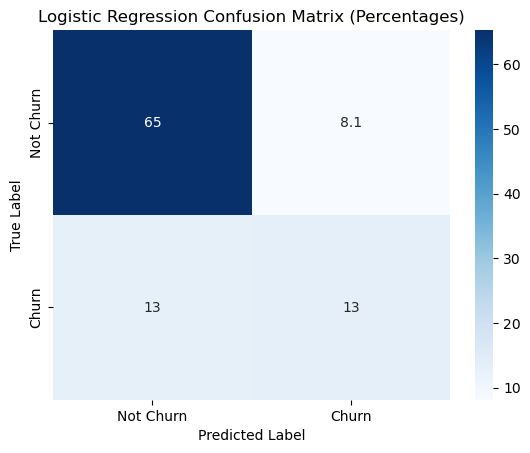

In [55]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Calculate the total number of samples
total_samples = np.sum(cm)

# Calculate the percentage of each cell in the confusion matrix
cm_percent = cm / total_samples * 100

class_labels = ['Not Churn', 'Churn']

# Create a pandas DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm_percent, index=class_labels, columns=class_labels)

# Plot the confusion matrix with annotations using seaborn's heatmap function
sns.heatmap(cm_df, annot=True, cmap='Blues')

# Customize the plot by adding a title and axis labels
plt.title('Logistic Regression Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

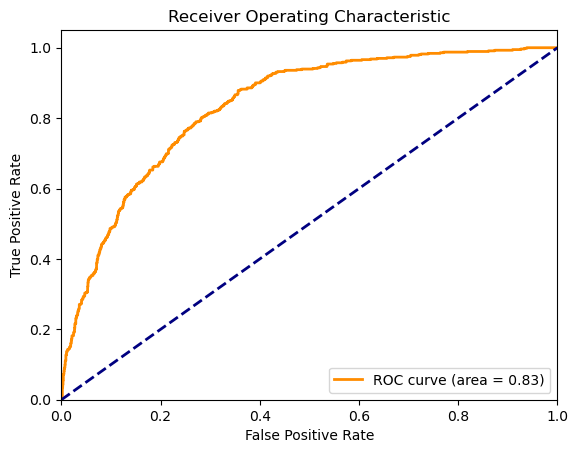

In [56]:
# Calculate the predicted probabilities for each class using current model
y_score = lr_best.predict_proba(X_test)

# Calculate the FPR, TPR, and classification thresholds using the roc_curve() function
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using matplotlib
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plot
plt.show()

# Support Vector Classifier
Support Vector Classification (SVC) is a type of supervised learning algorithm used for classification tasks. It works by finding the hyperplane that best separates the classes in the feature space. The hyperplane is chosen such that it maximizes the margin between the classes, which is defined as the distance between the hyperplane and the closest data points from each class. The data points that are closest to the hyperplane are known as support vectors.

## Implementation in Scikit-learn
Scikit-learn provides the "SVC" class for fitting the model. The parameters used by this module include:
- "C": Penalty parameter C of the error term.
- "kernel": Specifies the kernel type to be used in the algorithm (linear, polynomial, radial basis function (RBF), sigmoid).
- "degree": Degree of the polynomial kernel function ('poly').
- "gamma": Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
- "coef)": Independent term in kernel function.

SVC can be used for binary classification problems as well as multi-class classification problems. In scikit-learn, multi-class SVC can be performed using either one-vs-one or one-vs-rest methods.
Overall, SVC is a powerful tool for classification tasks and can be easily implemented using scikit-learn's built-in functions and classes.

In [57]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}


In [58]:
# Create SVC instance
svc = SVC(probability=True)

In [59]:
# Create GridSearchCV instance
grid_search = GridSearchCV(svc, param_grid=param_grid, cv=3)

In [ ]:
# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

In [ ]:
svc_best = grid_search.best_estimator_

pred = svc_best.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
confusion_matrix(y_test, pred)

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Calculate the total number of samples
total_samples = np.sum(cm)

# Calculate the percentage of each cell in the confusion matrix
cm_percent = cm / total_samples * 100

class_labels = ['Not Churn', 'Churn']

# Create a pandas DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm_percent, index=class_labels, columns=class_labels)

# Plot the confusion matrix with annotations using seaborn's heatmap function
sns.heatmap(cm_df, annot=True, cmap='Blues')

# Customize the plot by adding a title and axis labels
plt.title('SVC Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [ ]:
# Calculate the predicted probabilities for each class using current model
y_score = svc_best.predict_proba(X_test)

# Calculate the FPR, TPR, and classification thresholds using the roc_curve() function
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using matplotlib
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plot
plt.show()

# Ensembling
The "VotingClassifier" is a class in scikit-learn that allows you to combine multiple machine learning models to improve the overall performance of the model. The "VotingClassifier" trains different models using the chosen algorithms and returns the majority's vote as the classification result. It can be used for classification or regression tasks. Here are some key features of the "VotingClassifier":
- You can choose multiple different algorithms and combine them to one "VotingClassifier".
- You can specify whether to use hard voting or soft voting. Hard voting returns the majority class label, while soft voting returns the class label as argmax of the sum of predicted probabilities.
- You can assign specific weights to each classifier via the "weights" parameter. When weights are provided, the predicted class probabilities for each classifier are multiplied by their respective weights and then summed up. The class with the highest weighted sum is then chosen as the final predicted label.
- The "VotingClassifier" is available from version 0.17 of scikit-learn.

In [ ]:
# Create an instance of the VotingClassifier class
ensemble_clf = VotingClassifier(estimators=[('rf', rf_best), ('gb', gb_best),
                                           ('et', et_best), ('bc', bc_best),
                                           ('svc', svc_best)], voting='hard')

In [ ]:
ensemble_clf.fit(X_train, y_train)

In [ ]:
pred = ensemble_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
confusion_matrix(y_test, pred)

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Calculate the total number of samples
total_samples = np.sum(cm)

# Calculate the percentage of each cell in the confusion matrix
cm_percent = cm / total_samples * 100

class_labels = ['Not Churn', 'Churn']

# Create a pandas DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm_percent, index=class_labels, columns=class_labels)

# Plot the confusion matrix with annotations using seaborn's heatmap function
sns.heatmap(cm_df, annot=True, cmap='Blues')

# Customize the plot by adding a title and axis labels
plt.title('Ensemble Model Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [ ]:
# Calculate the predicted probabilities for each class using current model
y_score = ensemble_clf.predict_proba(X_test)

# Calculate the FPR, TPR, and classification thresholds using the roc_curve() function
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using matplotlib
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plot
plt.show()